                                                                                                Alex - Research - 9.3.21

## De Prado's approach: Triple Barrier labeling and meta labeling to for sizing

The purpose of this note book is to illustrate de Prado's approach. We will do the following:
1. Import the data in format of dollar bars instead of time bars 
2. Fit a primary model: Go long if close of a bar is below lower bollinger band vice versa for a short position (mean reversion trading)
3. Do event based sampling of the dollar bars: use cusum filter to pick only the bars with a significant increase/decrease in volatility (rationale: want to create a feature matrix with only relevant training samples)
4. Fit a meta (secondary model) on top of primary model to determine position sizing.
5. Compare primary model by itself vs. primary model and meta model. 


#### Prerequisites:

In [95]:
# Import all the necessary packages
import mlfinlab as ml
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

### 1. Data

- When working with financial time series it is common practice to discretize the continous data into a structured format referred to as "bars". A bar is usually given by open, high, low, close and represents a row in a data frame. 

- The most widely used bar type is based on time (e.g. hourly, daily, etc.). The issue with this sampling technique is that markets do not process information at a constant time interval. This implies that time bars oversample information during low-activity periods and undersample information during high-activity periods. Further they exhibit poor statistical properties like serial correlation, heteroscedasticity and non-normality. 

- To mitigate these short comings de Prado recommends volume, tick or dollar bars which contain better statistical properties for ML.

In [96]:
# Read in the dollar bars
data = pd.read_csv('C:/Users/axarz/Desktop/Thesis/sample_dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)


In [97]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


### 2. Fit a primary model for side: 

- We will now "fit" the primary model that gives us directional bias, i.e. the trades. 
- It will be a mean reversion approach based on bollinger bands

In [98]:
# define helper functions first
def relative_strength_index(df, n):
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI


def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df


def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band



Let's augment the bars with the upper and lower bollinger bands:

In [99]:

# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(5)


,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2011-10-28 20:01:08.417,1281.00,1282.25,1280.50,1282.00,55020,70502015.50,5167,1277.115216,1289.502333,1264.728099
2012-06-15 19:47:56.386,1334.00,1335.50,1333.50,1335.25,52485,70039053.00,9705,1326.605473,1336.699914,1316.511032
2012-04-12 20:00:01.159,1382.75,1383.50,1382.50,1383.00,50611,70002614.75,4860,1374.655793,1386.088232,1363.223354
2012-01-27 15:59:34.462,1310.00,1311.25,1308.25,1310.00,53487,70048597.00,14463,1314.405364,1321.754270,1307.056458
2011-09-16 13:38:55.005,1208.00,1209.75,1207.25,1208.25,57913,70000740.75,15532,1196.823489,1211.389109,1182.257868


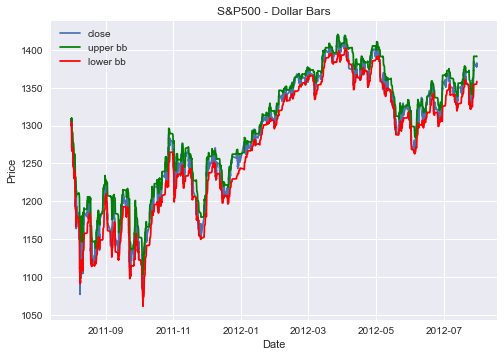

In [100]:
# let's take a look
plt.style.use('seaborn')
plt.title('S&P500 - Dollar Bars')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data.close, label= "close")
plt.plot(data.upper, color= "g", label= "upper bb")
plt.plot(data.lower, color= "r", label= "lower bb")
plt.legend()
plt.show()

Compute the trading signals

In [101]:

rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

# Sides
data['side'] = np.nan 
long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Important: remove Look ahead bias by lagging the signal for one bar !
data['side'] = data['side'].shift(1)

data.head(10)


,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2011-08-01 13:56:56.220,1293.25,1294.00,1292.00,1292.25,54159,70025279.50,12010,1300.315764,1307.910651,1292.720876,13.0,NaN
2011-08-01 14:00:21.448,1292.25,1292.75,1286.75,1286.75,54266,70000564.25,10157,1299.136791,1308.500955,1289.772626,9.0,1.0
2011-08-01 14:01:38.747,1286.75,1287.00,1284.00,1284.50,54475,70034099.00,8778,1297.922642,1308.843635,1287.001649,7.0,1.0
2011-08-01 14:03:22.782,1284.50,1285.00,1278.75,1279.00,54589,70000494.25,10823,1296.418749,1309.539297,1283.298202,5.0,1.0
2011-08-01 14:04:31.604,1279.00,1281.50,1276.00,1276.00,55049,70397187.25,10651,1294.858757,1309.982621,1279.734893,5.0,1.0
2011-08-01 14:06:25.239,1276.00,1280.00,1275.50,1279.75,54790,70002257.25,11580,1293.745832,1309.504890,1277.986773,4.0,1.0
2011-08-01 14:09:04.277,1279.75,1283.00,1278.50,1283.00,54639,70002429.50,10472,1292.980641,1308.734767,1277.226514,20.0,NaN
2011-08-01 14:12:51.262,1283.00,1283.25,1279.25,1281.50,54654,70002637.75,10166,1292.188469,1308.018216,1276.358723,22.0,NaN
2011-08-01 14:16:55.480,1281.50,1283.25,1280.25,1282.50,54606,70003307.25,10689,1291.539294,1307.260762,1275.817826,22.0,NaN


Save this raw data before proceeding. Will need it later for the feautures for the secondary model. 

In [102]:
# Save the raw data
raw_data = data.copy()

Filter the data now to only contain samples with trading signals

In [103]:
# Drop the NaN values from our data set, i.e. we sample the bars where side == 1 or -1
data.dropna(axis=0, how='any', inplace=True)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2011-08-01 14:00:21.448,1292.25,1292.75,1286.75,1286.75,54266,70000564.25,10157,1299.136791,1308.500955,1289.772626,9.0,1.0
2011-08-01 14:01:38.747,1286.75,1287.00,1284.00,1284.50,54475,70034099.00,8778,1297.922642,1308.843635,1287.001649,7.0,1.0
2011-08-01 14:03:22.782,1284.50,1285.00,1278.75,1279.00,54589,70000494.25,10823,1296.418749,1309.539297,1283.298202,5.0,1.0
2011-08-01 14:04:31.604,1279.00,1281.50,1276.00,1276.00,55049,70397187.25,10651,1294.858757,1309.982621,1279.734893,5.0,1.0
2011-08-01 14:06:25.239,1276.00,1280.00,1275.50,1279.75,54790,70002257.25,11580,1293.745832,1309.504890,1277.986773,4.0,1.0


### 3. Event based sampling of the dollar bars using cusum filter

So far so good. De Prado recommends to go even a step further and proposes event based sampling:

- use cusum filter to sample only the bars where there was a significant increase or decrease in volatility. 
- the sampled/remaining bars constitute "relevant" training examples that should yield informative features later (cf. AFML, Ch. 2.5.2). 

In [104]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# i.e. we use cusum filter to get the events where there is a significant change in volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-08-02':'2012-07-30'].mean() * 0.1)


Now comes triple barrier labeling into play:

- We have event based sampled the bars (**one could interpret them as trades now**) 
- Now we will label them, i.e. check whether tp/sl bound was touched first

In [105]:
# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

# use triple barrier method to get labels and meta labels
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events, #so we enter on the CUSUM events, i.e. events with signif. changes in vola
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])


labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.head(5)


2021-03-09 11:28:15.859686 100.0% apply_pt_sl_on_t1 done after 0.07 minutes. Remaining 0.0 minutes.


,ret,trgt,bin,side
2011-08-02 17:02:16.995,-0.007708,0.001658,0,1.0
2011-08-02 18:06:11.084,-0.004954,0.001484,0,1.0
2011-08-02 19:45:56.176,-0.017726,0.003248,0,1.0
2011-08-03 14:37:04.871,-0.002433,0.010390,0,1.0
2011-08-03 14:44:34.209,-0.003443,0.011904,0,1.0


In the above labels df we have:
- side: directional trade of primary model(1 for long; -1 for short)
- bin: meta label (1 if primary model was correct, i.e. trade successful; 0 otherwise)
- ret: return of the trade 

Confusion Matrix
[[  0 258]
 [  0 233]]

Accuracy
0.4745417515274949


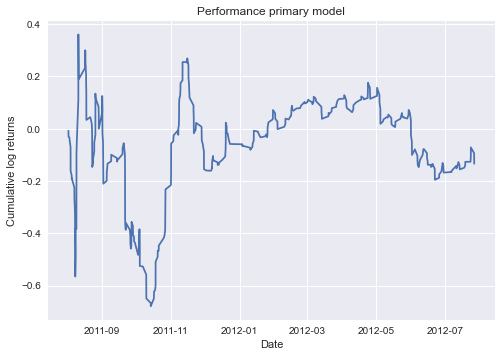

In [107]:
### Results of primary model 
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']


print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

# compute log returns
log_r = np.log(1+labels.ret)
cusum_log_r = log_r.cumsum()
plt.plot(cusum_log_r)
plt.title("Performance primary model")
plt.xlabel('Date')
plt.ylabel('Cumulative log returns')
plt.show()

### 4. Fit meta model

In this section we will 
- construct features, i.e. augment the raw data
- use the meta labels and the features to fit a random forest


In [108]:
## Features

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation
window_autocorr = 50
raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# Add Trending signals
raw_data['sma'] = np.nan
long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

# Re compute sides
raw_data['side'] = np.nan

# long signal if close is below lower bb
long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

#remove look ahead bias (!)
raw_data = raw_data.shift(1)



In [109]:
# Let's check it out 
raw_data.head(5)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,...,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
date_time,,,,,,,,,,,,,,,,,,,,,
2011-08-01 13:56:56.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 14:00:21.448,1293.25,1294.00,1292.00,1292.25,54159.0,70025279.50,12010.0,1300.315764,1307.910651,1292.720876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 14:01:38.747,1292.25,1292.75,1286.75,1286.75,54266.0,70000564.25,10157.0,1299.136791,1308.500955,1289.772626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 14:03:22.782,1286.75,1287.00,1284.00,1284.50,54475.0,70034099.00,8778.0,1297.922642,1308.843635,1287.001649,...,NaN,NaN,-0.004265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 14:04:31.604,1284.50,1285.00,1278.75,1279.00,54589.0,70000494.25,10823.0,1296.418749,1309.539297,1283.298202,...,NaN,NaN,-0.001750,-0.004265,NaN,NaN,NaN,NaN,NaN,NaN


Now of course we will have down sample again to our event based bars from earlier. In plain english: get our bars/trades from primary model

In [111]:
#sample only the bars with significant changes in volatility
X = raw_data.loc[labels.index, :]
y = labels['bin'] # the meta labels

#throw out all the stuff that is not of interest
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)
X.head()


,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-08-02 17:02:16.995,16.0,1.0,-0.000990,-0.000990,-0.004339,-0.005516,-0.006299,-0.004732,0.001709,-0.024846,0.030397,-0.055224,0.226567,0.122310,-0.003359,-0.001183,-0.000788,0.001576,-0.000591,-1.0
2011-08-02 18:06:11.084,19.0,1.0,-0.002381,-0.002379,-0.002971,-0.005533,-0.005925,-0.005336,0.001762,-0.012131,0.013186,-0.193096,0.241242,0.083327,-0.000594,-0.002572,-0.000395,0.000593,0.002374,-1.0
2011-08-02 19:45:56.176,25.0,1.0,-0.002390,-0.002387,-0.002387,-0.003180,-0.005355,-0.007717,0.001723,0.026686,-0.181886,-0.124395,0.193267,-0.017387,0.000000,-0.000795,-0.002184,-0.002377,0.001188,-1.0
2011-08-03 14:37:04.871,24.0,1.0,-0.002624,-0.002620,-0.004627,-0.003424,-0.006625,-0.009013,0.001713,0.034175,-0.134653,-0.011515,-0.083964,-0.118366,-0.002014,0.001208,-0.003217,-0.002406,-0.001601,-1.0
2011-08-03 14:44:34.209,17.0,1.0,0.000000,0.000000,-0.001014,-0.004244,-0.006853,-0.008851,0.001704,0.072997,-0.083414,-0.002388,-0.028741,-0.036896,-0.001014,-0.003239,-0.002624,-0.002014,0.001208,-1.0


In [116]:

# Split the data now for fitting
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.head(5)

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-08-02 17:02:16.995,16.0,1.0,-0.000990,-0.000990,-0.004339,-0.005516,-0.006299,-0.004732,0.001709,-0.024846,0.030397,-0.055224,0.226567,0.122310,-0.003359,-0.001183,-0.000788,0.001576,-0.000591,-1.0
2011-08-02 18:06:11.084,19.0,1.0,-0.002381,-0.002379,-0.002971,-0.005533,-0.005925,-0.005336,0.001762,-0.012131,0.013186,-0.193096,0.241242,0.083327,-0.000594,-0.002572,-0.000395,0.000593,0.002374,-1.0
2011-08-02 19:45:56.176,25.0,1.0,-0.002390,-0.002387,-0.002387,-0.003180,-0.005355,-0.007717,0.001723,0.026686,-0.181886,-0.124395,0.193267,-0.017387,0.000000,-0.000795,-0.002184,-0.002377,0.001188,-1.0
2011-08-03 14:37:04.871,24.0,1.0,-0.002624,-0.002620,-0.004627,-0.003424,-0.006625,-0.009013,0.001713,0.034175,-0.134653,-0.011515,-0.083964,-0.118366,-0.002014,0.001208,-0.003217,-0.002406,-0.001601,-1.0
2011-08-03 14:44:34.209,17.0,1.0,0.000000,0.000000,-0.001014,-0.004244,-0.006853,-0.008851,0.001704,0.072997,-0.083414,-0.002388,-0.028741,-0.036896,-0.001014,-0.003239,-0.002624,-0.002014,0.001208,-1.0


In [117]:
# Checking if we have somewhat balanced classes
y.value_counts()

0    258
1    233
Name: bin, dtype: int64

In [118]:
# hyperparameters for random forest

parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    


def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']


# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)


[0.51083121 0.47849318 0.47906922 0.47218956 0.48453149 0.48973735
 0.4948423  0.51463405 0.48942509 0.48343861 0.47099229 0.49098995
 0.49838383 0.49546921 0.50702988 0.54557307 0.51609355 0.49401053
 0.51203027 0.51077815 0.50598861 0.49791576 0.49078366 0.50099186
 0.50119959 0.51286443 0.51317715 0.50974043 0.51828034 0.48239536
 0.51328066 0.5006765  0.52119538 0.52327928 0.51953123]
10 4 42


In [119]:
# fit random forest
rf = RandomForestClassifier(max_depth = depth, n_estimators = n_estimator,
                            criterion ='entropy', random_state = c_random_state)
rf.fit(X_train, y_train.values.ravel())


RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=10,
                       random_state=42)

Check how the random forest performed


Accuracy - IS
0.8010204081632653

Accuracy - OOS
0.5353535353535354


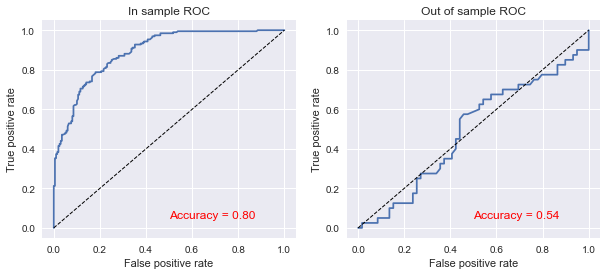

In [151]:
# In sample Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

print('')
print("Accuracy - IS")
print(accuracy_score(y_train, y_pred))



# OOS Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_predv = rf.predict(X_validate)
fpr_rfv, tpr_rfv, _ = roc_curve(y_validate, y_pred_rf)
print('')
print("Accuracy - OOS")
print(accuracy_score(y_validate, y_predv))


#Plot
fig , (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(fpr_rf, tpr_rf)
ax1.set_title('In sample ROC')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.text(0.5, 0.05, 'Accuracy = 0.80', fontsize=12,  color='red')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

ax2.plot(fpr_rfv, tpr_rfv)
ax2.set_title('Out of sample ROC')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.text(0.5, 0.05, 'Accuracy = 0.54', fontsize=12,  color='red')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)


From the out of sample roc curve we can see that the random forest can be parametrized in such way that it yields slightly better than random results.

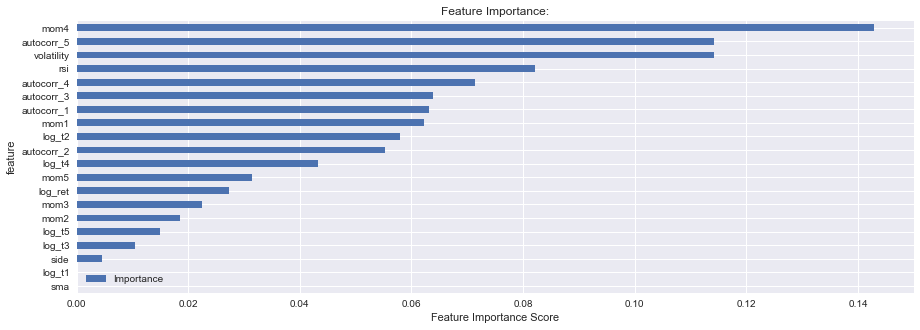

In [152]:
# Let's look at feature Importance as well
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()


### 5. Primary model vs. meta model (primary model + secondary model)

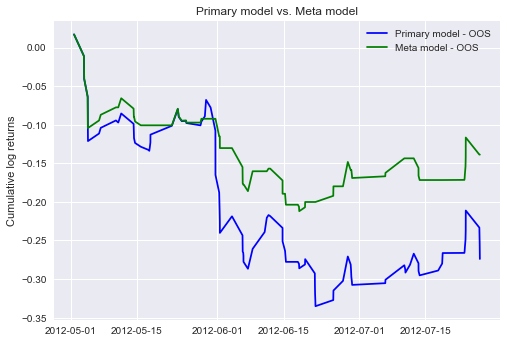

In [167]:

test_dates = X_validate.index
primary_lr = np.log(1 + labels.loc[test_dates, 'ret'])
primary_cusum = primary_lr.cumsum()
meta_lr = primary_lr * y_predv
meta_cusum = meta_lr.cumsum()

plt.plot(primary_cusum, "b", label = "Primary model - OOS")
plt.plot(meta_cusum, "g", label = "Meta model - OOS")
plt.title("Primary model vs. Meta model")
plt.legend()
plt.ylabel("Cumulative log returns")
plt.show()


In [171]:
# lets also look at some statistics instead of just a PnL curve
perf_func = pf.timeseries.perf_stats

def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets



primary_r = get_daily_returns(labels.loc[test_dates, 'ret'])

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_r, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

meta_r = get_daily_returns(labels.loc[test_dates, 'ret']*y_predv)

perf_stats_all = perf_func(returns=meta_r, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

print(perf_stats_df)


                     Primary Model  Meta Model
Annual return            -0.693470   -0.468970
Cumulative returns       -0.252423   -0.144203
Annual volatility         0.434043    0.283077
Sharpe ratio             -2.499123   -2.092530
Calmar ratio             -2.336430   -2.291298
Stability                 0.640379    0.444431
Max drawdown             -0.296808   -0.204674
Omega ratio               0.594760    0.603546
Sortino ratio            -2.833204   -2.538762
Skew                     -1.025872   -0.530980
Kurtosis                  1.209238    3.031978
Tail ratio                0.466715    0.552058
Daily value at risk      -0.058989   -0.038015


#### Some important things to note

- the strategy of the prime model is obviously complete bogus and just served for illustration purposes
- the features for the secondary model were not differenced nor were the samples weighted. The latter is crucial in case the meta labels depend on common returns (this usually only applies when using the triple barrier for labeling)
- **We will use Ernie Chan's approach which uses the side of past strategy returns as meta labels. This means we don't need triple barrier labeling (and probably no sample weighting since the meta labels are not concurrent - cf. AFML, ch. 4**